# Imports

In [1]:
! python --version

Python 3.9.5


In [2]:
!pip install tensorflow_hub
#!pip install keras tf-models-official pydot graphviz

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
from official.official import nlp

from official.official.nlp import bert

from official.official.nlp.bert import tokenization as tokenization
from official.official import modeling as modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
from IPython.core.debugger import set_trace

#%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="dark_background")

In [4]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

In [7]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils




# from official import nlp

# from official.modeling import tf_utils
# from official.nlp import bert
# import official.nlp.bert.bert_models
# import official.nlp.bert.configs
# import official.nlp.bert.run_classifier
# import official.nlp.bert.tokenization as tokenization
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('CPU') else "NOT AVAILABLE")

Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


# Data

In [8]:
SENTIMENT_LABELLED_DATA_FILEPATH = '..\Data\Sentiment Analysis Dataset.csv'
txt_data = pd.read_csv(SENTIMENT_LABELLED_DATA_FILEPATH , sep='|', names=['col1'])

#split data into columns with ','
txt_data = txt_data.col1.str.split(',',  3, expand=True)
txt_data.columns = list(txt_data.iloc[0])
txt_data = txt_data.drop(0)
txt_data.index = np.subtract(txt_data.index, 1)
# x = txt_data.groupby('Sentiment')
# l=[x.get_group(i)['SentimentText'] for i in x.groups]
df = pd.concat([txt_data['SentimentText'], txt_data['Sentiment']], axis = 1)
df.columns = ['text', 'target']

In [9]:
df.head()

,text,target
0,is so sad for my APL frie...,0
1,I missed the New Moon trail...,0
2,omg its already 7:30 :O,1
3,.. Omgaga. Im sooo im gunna CRy. I'...,0
4,i think mi bf is cheating on me!!! ...,0


We have two classes in the dataset

In [10]:
df.target.unique()

array(['0', '1'], dtype=object)

Let's check how equally distributed those classes are.

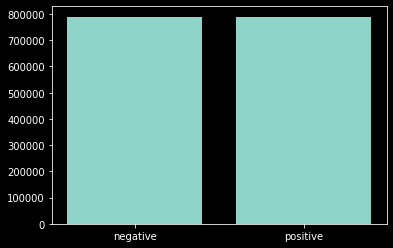

In [11]:
classes = df.target.unique()
counts = []

for i in classes:
  count = len(df[df.target==i])
  counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

## Train/test split

In [12]:
sample_size = int(len(df)*0.03)
sampleDf = df.sample(sample_size, random_state=23)
x = sampleDf.text.values
y = sampleDf.target.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32)

In [13]:
x.shape

(47335,)

## Label Encoding

In [14]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

In [15]:
dummy_y_train


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [16]:
encoder_fname = 'twitter_classes.npy'
my_wd = './'
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

In [17]:
# encoder = LabelEncoder()
# encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

## Tokenization

In [18]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=False)

OSError: SavedModel file does not exist at: C:\Users\Konst\AppData\Local\Temp\tfhub_modules\3e9209b9f2a53dfa4e6d93250dfceb5e64d73b66\{saved_model.pbtxt|saved_model.pb}

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
do_lower_case

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

In [ ]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

tweets = tf.ragged.constant([
    encode_names(n) for n in x_train])

In [ ]:
print('Tokenized Tweets shape', tweets.shape.as_list())

In [ ]:
tokenizedTweet = tokenizer.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizer.convert_tokens_to_ids([i]))

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets.shape[0]
input_word_ids = tf.concat([cls, tweets], axis=-1)
_ = plt.pcolormesh(input_word_ids[0:10].to_tensor())

## Mask and input type

In [ ]:
input_word_ids

In [ ]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

In [ ]:
type_cls = tf.zeros_like(cls)
type_tweet = tf.ones_like(tweets)
input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [ ]:
input_type_ids

## Remake into a function for normal use

In [ ]:
lens = [len(i) for i in input_word_ids]

In [ ]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

In [ ]:
max_seq_length = int(1.5*max_seq_length)
print('Max length is:', max_seq_length)

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

And now we preprocess inputs.

In [ ]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

#  MODEL

## Initial training

In [ ]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

# output = tf.keras.layers.Dense(100, activation='relu')(pooled_output)

# output = tf.keras.layers.Dense(1, activation="sigmoid", name='output')(output)

output = tf.keras.layers.Dropout(rate=0.1)(pooled_output)
output = tf.keras.layers.Dense(768, activation='relu')(output)
output = tf.keras.layers.Dense(400, activation='relu')(output)
output = tf.keras.layers.Dense(200, activation='relu')(output)
output = tf.keras.layers.Dense(100, activation='relu')(output)
output = tf.keras.layers.Dense(num_class, activation='sigmoid', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [ ]:
epochs = 3
batch_size = 20  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=2e-5,
    name='Adam'
)

# optimizer = nlp.optimization.create_optimizer(
#     2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
model.compile(optimizer = optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# tensorflow-gpu test
# import tensorflow as tf
# sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

In [ ]:
model_fname = 'model_BERT_non-trainable'
my_wd = './'

model.save(os.path.join(my_wd, model_fname))

In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
plot_history(history)

## Tokenizer load

In [ ]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [ ]:
tokenizedTweet = tokenizerSaved.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizerSaved.convert_tokens_to_ids([i]))

## Second training itteration

In [ ]:
plot_history(history)

### Data

In [ ]:
sample_size = int(len(df)*0.05)
sampleDf = df.sample(sample_size, random_state=42)  # notice the random state changes
x = sampleDf.text.values
y = sampleDf.target.values
x_train2, x_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.20, random_state=42)  # notice the random state changes

In [ ]:
classes = sampleDf.target.unique()
print(classes)
counts = []

for i in classes:
  count = len(sampleDf[sampleDf.target==i])
  counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

#### Label Encoding
Now we need to encode labels again. Good thing we have our label encoder saved.

In [ ]:
encoder_fname = 'twitter_classes.npy'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

encoded_Y_test2 = encoder.transform(y_test2)
encoded_Y_train2 = encoder.transform(y_train2)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test2 = np_utils.to_categorical(encoded_Y_test2)
dummy_y_train2 = np_utils.to_categorical(encoded_Y_train2)

#### Input preprocessing
As we did before we need to tokenize our inputs (tweets) as `input_word_ids` and then add `input_mask` and `input_type`. As we saved our model, we can use it to build our tokenizer as it was.

In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
print('Max sequence length is:', max_seq_length)

In [ ]:
model.summary()

In [ ]:
X_train2 = bert_encode(x_train2, tokenizerSaved, max_seq_length)
X_test2 = bert_encode(x_test2, tokenizerSaved, max_seq_length)

In [ ]:
x_train2[0]

### Training

In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))
new_model.summary()

In [ ]:
tf.keras.utils.plot_model(new_model, show_shapes=True, dpi=48)

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)  # OLD
print("Old testing Accuracy:  {:.4f}".format(accuracy))

loss, accuracy = new_model.evaluate(X_test2, dummy_y_test2, verbose=False)  # NEW
print("New testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
epochs = 3
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train2)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

In [ ]:
optimizer = nlp.optimization.create_optimizer(
    2e-6, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [ ]:
new_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history2 = new_model.fit(X_train2,  # using new training set
                         dummy_y_train2,  # using new training set
                         epochs=epochs,
                         batch_size=batch_size,
                         validation_data=(X_test, dummy_y_test),  # using old test dataset
                         verbose=1)

In [ ]:
for i in history2.history:
  for ele in history2.history[i]:
    history.history[i].append(ele)

In [ ]:
plot_history(history)

# Is BERT worth it?

# Test

We need to check in with our label encoder to get our classes.

In [ ]:
encoder_fname = 'twitter_classes.npy'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

This is how our classes are encoded for the model.

In [ ]:
encoder.classes_

Input preprocessing.

In [ ]:
tweet = ['SLEEPY JOE BIDEN IS PROPOSING THE BIGGEST TAX HIKE IN OUR COUNTRIES HISTORY! CAN ANYBODY REALLY VOTE FOR THIS?']
inputs = bert_encode(string_list=list(tweet), 
                     tokenizer=tokenizerSaved, 
                     max_seq_length=240)

Prediction.

In [ ]:
prediction = new_model.predict(inputs)
print(prediction)
print('Tweet is', 'positive' if encoder.classes_[np.argmax(prediction)]==4 else 'negative')

In [ ]:
inputs